# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("./lfw/*/*"))
dog_files = np.array(glob("./dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
human_files[0]

'./lfw/Andy_Wisecarver/Andy_Wisecarver_0001.jpg'

In [3]:
human_files[1]

'./lfw/Stanley_Tong/Stanley_Tong_0001.jpg'

In [4]:
dog_files[0]

'./dog_images/test/090.Italian_greyhound/Italian_greyhound_06149.jpg'

In [5]:
dog_files[1]

'./dog_images/test/090.Italian_greyhound/Italian_greyhound_06115.jpg'

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 0


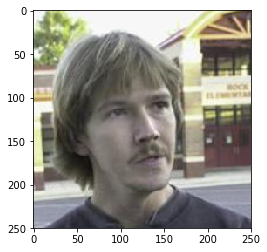

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)
 - Human face percentage of human files:  98.00%
 - Human face percentage of dog files:     7.00%

In [8]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
# Detect human faces from a collection of human files
total_face_detected = 0
for human_file in human_files_short:
    if face_detector(img_path=human_file) == True:
        total_face_detected += 1

print("Human face percentage of human files: %6.2f%%" % \
      ((total_face_detected / len(human_files_short)) * 100))

# Detect human faces from a collection of dog files
total_face_detected = 0
for dog_file in dog_files_short:
    if face_detector(img_path=dog_file) == True:
        total_face_detected += 1

print("Human face percentage of dog files:   %6.2f%%" % \
      ((total_face_detected / len(dog_files_short)) * 100))

Human face percentage of human files:  98.00%
Human face percentage of dog files:     7.00%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [9]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [10]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Use CUDA:",  use_cuda)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Use CUDA: True


Get class index to label converter for ImageNet model.

In [11]:
import pickle
from urllib.request import urlopen

clsidx_to_labels = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [12]:
def display_image_tensor(image_t, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image_np = image_t.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image_np = np.clip(image_np, 0, 1)
    
    ax.imshow(image_np)
    
    return ax

In [13]:
def preprocess_image(image_pil):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # scale
    width, height = image_pil.size
    shortest_side = min(width, height)
    new_ratio = shortest_side / 256
    new_width, new_height = (int(width/new_ratio), int(height/new_ratio))
    image_pil = image_pil.resize((new_width, new_height))
    # crop
    width, height = image_pil.size
    new_width, new_height = (224, 224)
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    image_pil = image_pil.crop((left, top, right, bottom))
    # convert to RGB
    if image_pil.mode != "RGB":
        image_pil = image_pil.convert("RGB")
    # normalize
    image_np = np.array(image_pil, dtype=np.float32)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    image_np = ((image_np / 255) - mean) / std
    # transpoose to channel first (CHW)
    image_np = image_np.transpose((2, 0, 1))
    
    return image_np

In [14]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image_pil = Image.open(img_path)
    image_np = preprocess_image(image_pil)
    image_tensor = torch.tensor(np.array([image_np]))
    if use_cuda:
        image_tensor = image_tensor.cuda()
    output = VGG16(image_tensor)
    prediction = output.topk(1)
    if use_cuda:
        prediction = prediction[1].detach().cpu().numpy()

    return prediction[0][0]

In [15]:
def display_and_predict(image_path):
    image_pil = Image.open(image_path)
    image_np = preprocess_image(image_pil)
    display_image_tensor(torch.tensor(image_np))
    plt.show()

    prediction = VGG16_predict(image_path)
    print(prediction, ":", clsidx_to_labels[prediction])

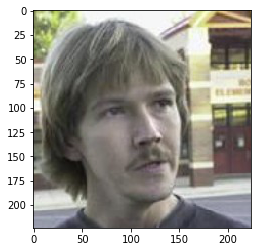

834 : suit, suit of clothes


In [16]:
display_and_predict(image_path='./lfw/Andy_Wisecarver/Andy_Wisecarver_0001.jpg')

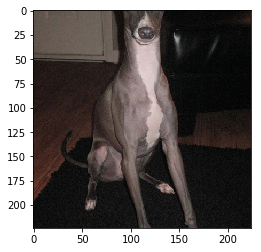

171 : Italian greyhound


In [17]:
display_and_predict(image_path='./dog_images/test/090.Italian_greyhound/Italian_greyhound_06149.jpg')

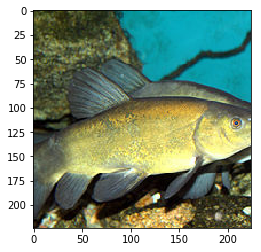

0 : tench, Tinca tinca


In [18]:
display_and_predict(image_path='./test_images/300px-Tinca_tinca_Prague_Vltava_3.jpg')

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [19]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    if prediction >= 151 and prediction <= 268:
        is_dog = True
    else:
        is_dog = False
    
    return is_dog # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
 - Dog percentage of human files:   0.00%
 - Dog percentage of dog files:    98.00%

In [20]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Detect dog from a collection of human files
total_dog_detected = 0
false_positives = []
for human_file in human_files_short:
    if dog_detector(img_path=human_file) == True:
        total_dog_detected += 1
        false_positives.append(human_file)

print("Dog percentage of human files: %6.2f%%" % \
      ((total_dog_detected / len(human_files_short)) * 100))
print("False Positives:")
for false_positive in false_positives:
    print(" -", false_positive)

# Detect dog from a collection of dog files
total_dog_detected = 0
false_negatives = []
for dog_file in dog_files_short:
    if dog_detector(img_path=dog_file) == True:
        total_dog_detected += 1
    else:
        false_negatives.append(dog_file)

print("")
print("Dog percentage of dog files:   %6.2f%%" % \
      ((total_dog_detected / len(dog_files_short)) * 100))
print("False Negatives:")
for false_negative in false_negatives:
    print(" -", false_negative)

Dog percentage of human files:   0.00%
False Positives:

Dog percentage of dog files:    98.00%
False Negatives:
 - ./dog_images/test/067.Finnish_spitz/Finnish_spitz_04648.jpg
 - ./dog_images/test/018.Beauceron/Beauceron_01310.jpg


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [21]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [22]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_dir = './dog_images/train'
valid_dir = './dog_images/valid'
test_dir = './dog_images/test'

# Data transformations
train_data_transforms = transforms.Compose([transforms.RandomResizedCrop(224), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                                 (0.229, 0.224, 0.225))])
valid_data_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                                 (0.229, 0.224, 0.225))])

# Datasets
train_datasets = datasets.ImageFolder(train_dir, transform=train_data_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform=valid_data_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform=valid_data_transforms)

# Data loader
batch_size = 20
num_workers = 12
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch = {}
loaders_scratch['train'] = train_loader
loaders_scratch['valid'] = valid_loader
loaders_scratch['test'] = test_loader

In [23]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 6680
    Root Location: ./dog_images/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None

In [24]:
valid_loader.dataset

Dataset ImageFolder
    Number of datapoints: 835
    Root Location: ./dog_images/valid
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None

In [25]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 836
    Root Location: ./dog_images/test
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
 - For training, I use random cropping to get the model to learn different positions of a same image for every iteration. Many models for image classification use input tensor size of 224x224 with 3-color channel. To avoid engineering debt when switching models, I just follow the commonly used input tensor size.
 - I do not use object translation and scaling as deep learning models have the capability to handle them. As dogs are bound by gravity, I will consider small degree of rotation at the cost of extra computing power.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), \
                               stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), \
                               stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), \
                               stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), \
                               stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3), \
                               stride=(1, 1), padding=(1, 1), bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(25088, 4096)
        self.linear2 = nn.Linear(4096, 133)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = F.dropout(x)
        x = self.linear2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [27]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=25088, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=133, bias=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
 - I want to build a model with both CNN and multi-layer perceptron (MLP) for better classification.
 - The input will be 224x224 flatten image with 3 color as the channels with 133 classes as the output.
 - The CNN need to be a bit deeper to avoid flatten layer to be so big that the model will not fit on GPU memory. 3 layers CNN model with 100 thousand nodes of flatten layer does not fit in my GPU memory. 4 layers CNN model has 800 MiB model size and 5 layers CNN model has 400 MiB model size.
 - Need the ReLU for activation function with both linear and non-linear portion that is cheaper to compute as compared to Sigmoid function.
 - Need max pooling and dropout to avoid over fitting and to reduce computational cost as well.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [28]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
import time

# To avoid following error
# OSError: image file is truncated (150 bytes not processed)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        ###################
        # train the model #
        ###################
        tic = time.time()
        train_loss = 0.0
        total_accumulated_train_loss = 0
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss 
            train_loss += loss.item()
            total_accumulated_train_loss += 1
            
            if batch_idx % 100 == 99:    # print training loss every specified number of mini-batches
                print('Epoch %2d, Batch %4d loss: %.16f' %
                      (epoch, batch_idx + 1, train_loss / total_accumulated_train_loss))
                train_loss = 0.0
                total_accumulated_train_loss = 0
            
        train_loss = train_loss / total_accumulated_train_loss
    
        toc = time.time()
        train_time = toc - tic
            
            
        ######################    
        # validate the model #
        ######################
        tic = time.time()
        valid_loss = 0.0
        class_correct = list(0. for i in range(133))
        class_total = list(0. for i in range(133))
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update  validation loss 
            valid_loss += loss.item() * data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) \
                      if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
            # calculate validation accuracy for each object class
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
                
        # calculate avg validation loss
        valid_loss = valid_loss / len(valid_loader.dataset)

        toc = time.time()
        valid_time = toc - tic

        print("Train Time          : %9d seconds" % int(train_time))
        print('Train Loss          : {:9.6f}'.format(train_loss))
        print("Validation Time     : %9d seconds" % int(valid_time))
        print('Validation Loss     : {:9.6f}'.format(valid_loss))
        valid_accuracy = (100. * np.sum(class_correct)) / np.sum(class_total)
        print('Validation Accuracy : %2d%% (%2d/%2d)' % (valid_accuracy, 
                                                         np.sum(class_correct), 
                                                         np.sum(class_total)))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Saving Checkpoint...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [29]:
# train the model
model_scratch = train(100, loaders_scratch, model_scratch, 
                      optimizer_scratch, criterion_scratch, 
                      use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch  1, Batch  100 loss: 4.8902647781372073
Epoch  1, Batch  200 loss: 4.8889791488647463
Epoch  1, Batch  300 loss: 4.8866277837753298
Train Time          :        33 seconds
Train Loss          :  4.886596
Validation Time     :         2 seconds
Validation Loss     :  4.884387
Validation Accuracy :  1% ( 9/835)
Epoch: 1 	Training Loss: 4.886596 	Validation Loss: 4.884387
Saving Checkpoint...
Epoch  2, Batch  100 loss: 4.8818601751327515
Epoch  2, Batch  200 loss: 4.8779250144958493
Epoch  2, Batch  300 loss: 4.8734543371200560
Train Time          :        34 seconds
Train Loss          :  4.866301
Validation Time     :         2 seconds
Validation Loss     :  4.864632
Validation Accuracy :  1% ( 9/835)
Epoch: 2 	Training Loss: 4.866301 	Validation Loss: 4.864632
Saving Checkpoint...
Epoch  3, Batch  100 loss: 4.8697775411605839
Epoch  3, Batch  200 loss: 4.8633338499069216
Epoch  3, Batch  300 loss: 4.8590065956115724
Train Time          :        34 seconds
Train Loss          :  4

Epoch 22, Batch  100 loss: 4.0360787987709044
Epoch 22, Batch  200 loss: 4.0432777714729307
Epoch 22, Batch  300 loss: 4.0646070027351380
Train Time          :        33 seconds
Train Loss          :  4.021505
Validation Time     :         2 seconds
Validation Loss     :  4.208084
Validation Accuracy :  7% (63/835)
Epoch: 22 	Training Loss: 4.021505 	Validation Loss: 4.208084
Epoch 23, Batch  100 loss: 3.9391958427429201
Epoch 23, Batch  200 loss: 4.0141541862487795
Epoch 23, Batch  300 loss: 4.0601045227050783
Train Time          :        33 seconds
Train Loss          :  4.061502
Validation Time     :         2 seconds
Validation Loss     :  4.085687
Validation Accuracy :  8% (68/835)
Epoch: 23 	Training Loss: 4.061502 	Validation Loss: 4.085687
Saving Checkpoint...
Epoch 24, Batch  100 loss: 3.9242927956581117
Epoch 24, Batch  200 loss: 3.9374016022682188
Epoch 24, Batch  300 loss: 3.9331577396392823
Train Time          :        33 seconds
Train Loss          :  3.995325
Validation 

Epoch 44, Batch  100 loss: 2.4078319239616395
Epoch 44, Batch  200 loss: 2.4998010122776031
Epoch 44, Batch  300 loss: 2.4083204495906831
Train Time          :        33 seconds
Train Loss          :  2.467874
Validation Time     :         2 seconds
Validation Loss     :  4.461247
Validation Accuracy : 12% (107/835)
Epoch: 44 	Training Loss: 2.467874 	Validation Loss: 4.461247
Epoch 45, Batch  100 loss: 2.3068788576126100
Epoch 45, Batch  200 loss: 2.3044116294384001
Epoch 45, Batch  300 loss: 2.4036228370666506
Train Time          :        33 seconds
Train Loss          :  2.358139
Validation Time     :         2 seconds
Validation Loss     :  4.408653
Validation Accuracy : 14% (118/835)
Epoch: 45 	Training Loss: 2.358139 	Validation Loss: 4.408653
Epoch 46, Batch  100 loss: 2.2446932160854338
Epoch 46, Batch  200 loss: 2.2637083959579467
Epoch 46, Batch  300 loss: 2.3253879046440122
Train Time          :        33 seconds
Train Loss          :  2.414703
Validation Time     :         

Epoch 66, Batch  100 loss: 1.3916324698925018
Epoch 66, Batch  200 loss: 1.5313007736206055
Epoch 66, Batch  300 loss: 1.5468728089332580
Train Time          :        33 seconds
Train Loss          :  1.601794
Validation Time     :         2 seconds
Validation Loss     :  4.799766
Validation Accuracy : 14% (121/835)
Epoch: 66 	Training Loss: 1.601794 	Validation Loss: 4.799766
Epoch 67, Batch  100 loss: 1.3631019869446754
Epoch 67, Batch  200 loss: 1.4271156084537506
Epoch 67, Batch  300 loss: 1.4439842027425767
Train Time          :        33 seconds
Train Loss          :  1.513050
Validation Time     :         2 seconds
Validation Loss     :  5.014405
Validation Accuracy : 15% (127/835)
Epoch: 67 	Training Loss: 1.513050 	Validation Loss: 5.014405
Epoch 68, Batch  100 loss: 1.3529380661249162
Epoch 68, Batch  200 loss: 1.3945441266894341
Epoch 68, Batch  300 loss: 1.3829393634200096
Train Time          :        33 seconds
Train Loss          :  1.279076
Validation Time     :         

Epoch 88, Batch  100 loss: 1.0346675826609135
Epoch 88, Batch  200 loss: 1.1391489437222482
Epoch 88, Batch  300 loss: 1.0826645023375749
Train Time          :        34 seconds
Train Loss          :  1.004291
Validation Time     :         2 seconds
Validation Loss     :  5.513407
Validation Accuracy : 14% (124/835)
Epoch: 88 	Training Loss: 1.004291 	Validation Loss: 5.513407
Epoch 89, Batch  100 loss: 1.0680568593740463
Epoch 89, Batch  200 loss: 1.0721326979994774
Epoch 89, Batch  300 loss: 1.0693483942747115
Train Time          :        34 seconds
Train Loss          :  1.038853
Validation Time     :         2 seconds
Validation Loss     :  5.337366
Validation Accuracy : 16% (134/835)
Epoch: 89 	Training Loss: 1.038853 	Validation Loss: 5.337366
Epoch 90, Batch  100 loss: 0.9850922465324402
Epoch 90, Batch  200 loss: 0.9549489809572697
Epoch 90, Batch  300 loss: 1.0860448840260506
Train Time          :        34 seconds
Train Loss          :  1.033872
Validation Time     :         

Training GPU utilization:
```
while sleep 0.2; do nvidia-smi --query-gpu=name,index,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv,noheader; done
```
```
GeForce GTX 1060, 0, 72, 98 %, 72 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 96 %, 75 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 96 %, 71 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 98 %, 72 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 96 %, 78 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 98 %, 68 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 97 %, 79 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 96 %, 71 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 98 %, 69 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 72, 96 %, 78 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 73, 97 %, 73 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 73, 97 %, 73 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 73, 96 %, 73 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 73, 96 %, 71 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 73, 96 %, 75 %, 6078 MiB, 2385 MiB, 3693 MiB
GeForce GTX 1060, 0, 73, 98 %, 73 %, 6078 MiB, 2385 MiB, 3693 MiB
```

Validation GPU utilization:
```
while sleep 0.2; do nvidia-smi --query-gpu=name,index,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv,noheader; done
```
```
GeForce GTX 1060, 0, 76, 4 %, 1 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 76, 47 %, 29 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 77, 64 %, 43 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 76, 26 %, 18 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 77, 71 %, 44 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 77, 83 %, 57 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 77, 86 %, 59 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 76, 33 %, 19 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 75, 17 %, 2 %, 6078 MiB, 1709 MiB, 4369 MiB
GeForce GTX 1060, 0, 75, 4 %, 1 %, 6078 MiB, 1709 MiB, 4369 MiB
```

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [30]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [31]:
# call test function
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.994809


Test Accuracy: 12% (101/836)


Testing GPU utilization:
```
while sleep 0.2; do nvidia-smi --query-gpu=name,index,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv,noheader; done
```
```
GeForce GTX 1060, 0, 64, 6 %, 1 %, 6078 MiB, 1711 MiB, 4367 MiB
GeForce GTX 1060, 0, 65, 59 %, 38 %, 6078 MiB, 1711 MiB, 4367 MiB
GeForce GTX 1060, 0, 66, 71 %, 45 %, 6078 MiB, 1711 MiB, 4367 MiB
GeForce GTX 1060, 0, 66, 62 %, 38 %, 6078 MiB, 1711 MiB, 4367 MiB
GeForce GTX 1060, 0, 67, 79 %, 56 %, 6078 MiB, 1711 MiB, 4367 MiB
GeForce GTX 1060, 0, 67, 47 %, 31 %, 6078 MiB, 1711 MiB, 4367 MiB
GeForce GTX 1060, 0, 67, 75 %, 57 %, 6078 MiB, 1711 MiB, 4367 MiB
GeForce GTX 1060, 0, 66, 5 %, 1 %, 6078 MiB, 1711 MiB, 4367 MiB
```

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [31]:
## TODO: Specify data loaders
loaders_transfer = {}
loaders_transfer['train'] = train_loader
loaders_transfer['valid'] = valid_loader
loaders_transfer['test'] = test_loader

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [32]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features
n_outputs = 133
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, n_outputs)
model_transfer.classifier[6] = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
 - Since the training data is small and the data is similar (pre-trained VGG16 model has dog's breed classification as well), I will just retrain layers at the end of ConvNet which is the last fully connected layers.
 - I will also change the number of output classes from 1000 to 133.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [33]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [34]:
# train the model
model_transfer = train(10, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, 
                       use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch  1, Batch  100 loss: 3.3865274965763090
Epoch  1, Batch  200 loss: 1.6881269937753678
Epoch  1, Batch  300 loss: 1.4143800318241120
Train Time          :        68 seconds
Train Loss          :  1.256013
Validation Time     :         7 seconds
Validation Loss     :  0.671052
Validation Accuracy : 79% (661/835)
Epoch: 1 	Training Loss: 1.256013 	Validation Loss: 0.671052
Saving Checkpoint...
Epoch  2, Batch  100 loss: 1.1349730503559112
Epoch  2, Batch  200 loss: 1.1592980498075485
Epoch  2, Batch  300 loss: 1.0436573249101639
Train Time          :        69 seconds
Train Loss          :  1.013706
Validation Time     :         7 seconds
Validation Loss     :  0.607202
Validation Accuracy : 81% (681/835)
Epoch: 2 	Training Loss: 1.013706 	Validation Loss: 0.607202
Saving Checkpoint...
Epoch  3, Batch  100 loss: 1.0217365473508835
Epoch  3, Batch  200 loss: 1.0022607558965684
Epoch  3, Batch  300 loss: 0.9589900392293930
Train Time          :        69 seconds
Train Loss          : 

Training GPU utilization:
```
while sleep 0.2; do nvidia-smi --query-gpu=name,index,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv,noheader; done
```
```
GeForce GTX 1060, 0, 73, 98 %, 80 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 82 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 83 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 99 %, 91 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 99 %, 81 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 83 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 84 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 87 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 100 %, 93 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 81 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 81 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 87 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 100 %, 98 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 80 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 83 %, 6078 MiB, 1787 MiB, 4291 MiB
GeForce GTX 1060, 0, 73, 98 %, 85 %, 6078 MiB, 1787 MiB, 4291 MiB
```

Validation GPU utilization:
```
while sleep 0.2; do nvidia-smi --query-gpu=name,index,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv,noheader; done
```
```
GeForce GTX 1060, 0, 81, 98 %, 81 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 99 %, 80 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 99 %, 83 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 80 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 80 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 81 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 84 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 80 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 80 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 79 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 83 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 83 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 79 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 80 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 86 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 80 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 82, 98 %, 82 %, 6078 MiB, 1779 MiB, 4299 MiB
GeForce GTX 1060, 0, 81, 98 %, 79 %, 6078 MiB, 1779 MiB, 4299 MiB
```

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.500595


Test Accuracy: 86% (723/836)


Testing GPU utilization:
```
while sleep 0.2; do nvidia-smi --query-gpu=name,index,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv,noheader; done
```
```
GeForce GTX 1060, 0, 63, 99 %, 82 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 99 %, 85 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 99 %, 85 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 99 %, 82 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 99 %, 82 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 98 %, 82 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 98 %, 82 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 98 %, 83 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 99 %, 83 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 64, 98 %, 81 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 98 %, 84 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 98 %, 80 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 98 %, 82 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 99 %, 85 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 98 %, 83 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 99 %, 83 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 98 %, 84 %, 6078 MiB, 1784 MiB, 4294 MiB
GeForce GTX 1060, 0, 65, 99 %, 79 %, 6078 MiB, 1784 MiB, 4294 MiB
```

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [43]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
#bar class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in train_datasets.classes]


def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_pil = Image.open(img_path)
    image_np = preprocess_image(image_pil)
    image_tensor = torch.tensor(np.array([image_np]))
    if use_cuda:
        image_tensor = image_tensor.cuda()
    output = model_transfer(image_tensor)
    prediction = output.topk(1)
    if use_cuda:
        prediction = prediction[1].detach().cpu().numpy()

    return class_names[prediction[0][0]]

In [44]:
predict_breed_transfer(img_path='./dog_images/test/090.Italian_greyhound/Italian_greyhound_06149.jpg')

'Italian greyhound'

In [47]:
predict_breed_transfer(img_path='./dog_images/test/091.Japanese_chin/Japanese_chin_06184.jpg')

'Japanese chin'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [65]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    # display image
    image_pil = Image.open(img_path)
    image_np = preprocess_image(image_pil)
    display_image_tensor(torch.tensor(image_np))
    plt.show()
    
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path=img_path) == True:
        print("Hello, Human!")
        print("Let me guess.")
        breed = predict_breed_transfer(img_path=img_path)
        breed_words = breed.split(' ')
        if len(breed_words) == 1:
            print("Your name is %s." % breed)
        else:
            print("Your name is %s, %s." % (breed_words[-1], breed))
        return
    
    if dog_detector(img_path=img_path) == True:
        print("Who's a good boy, %s..." % predict_breed_transfer(img_path=img_path))
        return
    
    print("hmm...")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
 - Face detection need a lot of improvements. May need better model to predict face.
 - There is at least one case in which both face and dog detection fail to detect human face. Other than better face detection, dog detection model need to include human face as one of the output classes.
 - The resemblance of dog to the corresponding human face is mostly off. Increasing accuracy of dog's breed prediction may help.

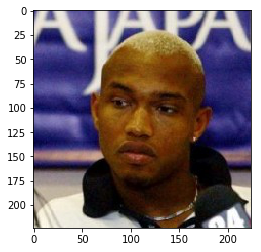

Hello, Human!
Let me guess.
Your name is hound, Pharaoh hound.


In [66]:
run_app("./lfw/El_Hadji_Diouf/El_Hadji_Diouf_0001.jpg")

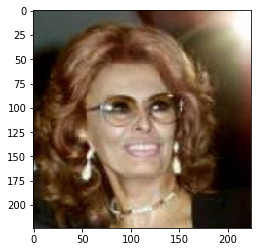

Hello, Human!
Let me guess.
Your name is spaniel, English springer spaniel.


In [67]:
run_app("./lfw/Sophia_Loren/Sophia_Loren_0006.jpg")

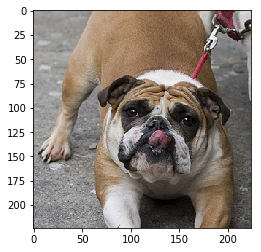

Who's a good boy, Bulldog...


In [68]:
run_app("./dog_images/test/040.Bulldog/Bulldog_02817.jpg")

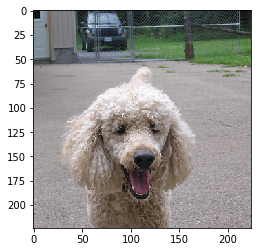

Who's a good boy, Poodle...


In [71]:
run_app("./dog_images/test/124.Poodle/Poodle_07925.jpg")

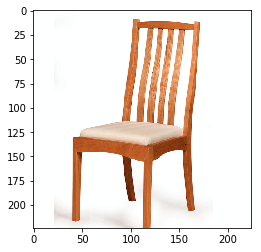

hmm...


In [69]:
run_app("./test_images/Screenshot.png")

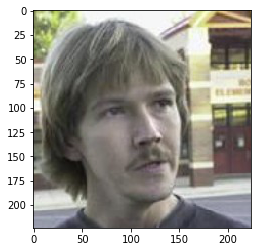

hmm...


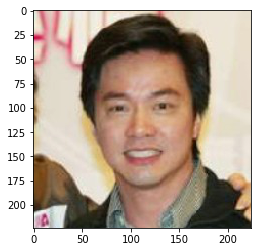

Hello, Human!
Let me guess.
Your name is Dachshund.


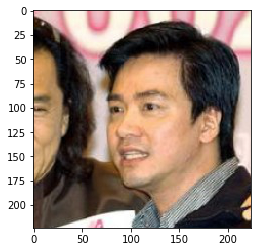

Hello, Human!
Let me guess.
Your name is Chihuahua.


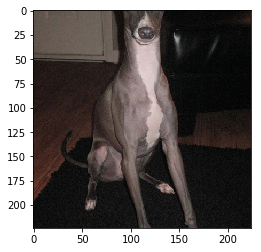

Hello, Human!
Let me guess.
Your name is greyhound, Italian greyhound.


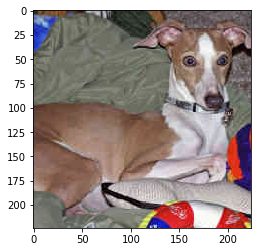

Who's a good boy, Italian greyhound...


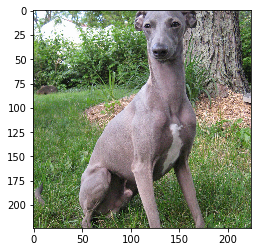

Who's a good boy, Italian greyhound...


In [70]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)